In [ ]:
import cv2                    # Librería para procesamiento de imágenes y visión computacional
import numpy as np            # Librería para operaciones numéricas
import matplotlib.pyplot as plt  # Librería para visualización de imágenes
import imageio                # Librería para crear y guardar archivos GIF animados


In [ ]:

# =========================
# 1. Cargar imagen binarizada desde archivo fijo
# =========================

# Cargar imagen en escala de grises desde archivo
img_gray = cv2.imread('imagen.jpg', cv2.IMREAD_GRAYSCALE)

# Validar que la imagen haya sido cargada correctamente
if img_gray is None:
    raise FileNotFoundError("No se encontró el archivo 'imagen.jpg'")

# Aplicar binarización inversa: fondo blanco (0), objetos negros (255)
_, binary = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY_INV)

# Convertir imagen binaria a formato BGR para poder dibujar en color
img_color = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)

# Crear listas para guardar los pasos de los GIFs
img_steps_contornos = []      # Para GIF solo con contornos
img_steps_etiquetado = []     # Para GIF con contornos y métricas


In [ ]:

# =========================
# 2. Detectar contornos
# =========================

# Detectar contornos externos de las figuras blancas en la imagen binaria
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


In [ ]:

# =========================
# 3. Procesar cada contorno
# =========================

# Crear copias de la imagen original para cada animación
img_contour = img_color.copy()
img_labelled = img_color.copy()

# Procesar cada contorno encontrado
for i, contour in enumerate(contours):
    # Calcular el área y perímetro del contorno
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    # Calcular el centroide (centro geométrico) usando momentos
    M = cv2.moments(contour)
    if M['m00'] != 0:
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
    else:
        cx, cy = 0, 0  # Evitar división por cero

    # Aproximar el contorno para clasificar la figura según el número de vértices
    approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)
    num_vertices = len(approx)
    if num_vertices == 3:
        shape = "Triángulo"
    elif num_vertices == 4:
        shape = "Cuadrado/Rectángulo"
    elif num_vertices > 4:
        shape = "Círculo"
    else:
        shape = "Desconocido"

    # --- GIF 1: solo contornos ---
    # Dibujar contorno actual en verde sobre la imagen
    cv2.drawContours(img_contour, [contour], -1, (0, 255, 0), 2)
    # Guardar copia del estado actual para la animación
    img_steps_contornos.append(cv2.cvtColor(img_contour.copy(), cv2.COLOR_BGR2RGB))

    # --- GIF 2: contorno + métrica + etiquetas ---
    # Dibujar el mismo contorno sobre otra copia
    cv2.drawContours(img_labelled, [contour], -1, (0, 255, 0), 2)
    # Dibujar un círculo rojo en el centroide
    cv2.circle(img_labelled, (cx, cy), 4, (0, 0, 255), -1)

    # Crear etiqueta con nombre, área, perímetro y coordenadas
    label = f"{shape}\nA={int(area)}\nP={int(perimeter)}\n({cx},{cy})"
    # Dibujar cada línea de la etiqueta en la imagen
    for j, line in enumerate(label.split('\n')):
        cv2.putText(img_labelled, line, (cx + 10, cy + 15 * j),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)

    # Guardar el estado actual con etiquetas para el GIF
    img_steps_etiquetado.append(cv2.cvtColor(img_labelled.copy(), cv2.COLOR_BGR2RGB))


In [ ]:

# =========================
# 4. Mostrar imagen final con matplotlib
# =========================

# Mostrar imagen final con todos los contornos y etiquetas usando matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img_labelled, cv2.COLOR_BGR2RGB))
plt.title("Contornos, métricas y clasificación")
plt.axis('off')
plt.show()


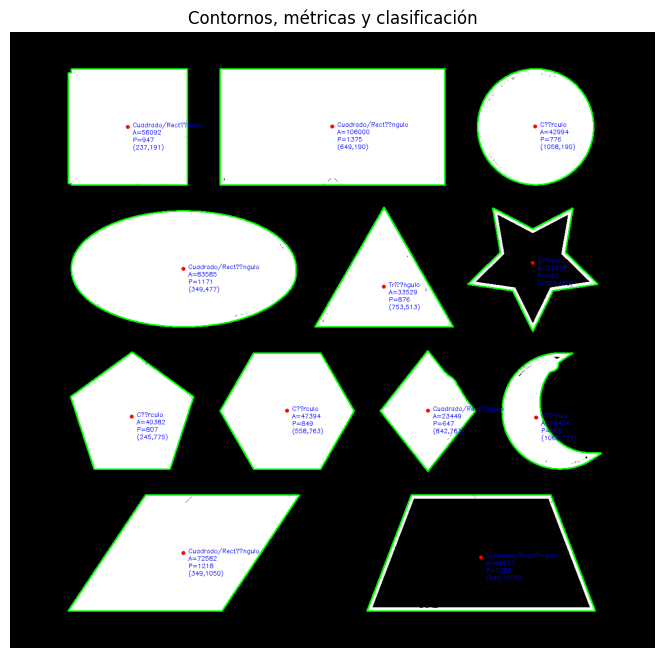

In [13]:

# =========================
# 5. Guardar los GIFs animados (loop explícito y bucle visual suave)
# =========================

# Definir cuántos frames extra se repite la última imagen para alargar su visibilidad
extra_frames = 15

# --- Contornos GIF ---
# Crear una secuencia: hacia adelante y luego hacia atrás (efecto de bucle suave)
contour_frames = img_steps_contornos + img_steps_contornos[::-1]
# Guardar GIF animado con 1 segundo por frame y loop infinito
imageio.mimsave('contornos.gif', contour_frames, duration=1.0, loop=0)

# --- Etiquetado GIF ---
# Repetir último frame para que la etiqueta se mantenga visible
final_frame = img_steps_etiquetado[-1]
labelled_frames = img_steps_etiquetado + [final_frame] * extra_frames + img_steps_etiquetado[::-1]
# Guardar GIF animado con etiquetas y duración lenta por frame
imageio.mimsave('etiquetado.gif', labelled_frames, duration=1.0, loop=0)
